# Data Audit & Visualization

This notebook inspects the existing datasets to understand their structure and quality before importing them into the new `AI_Pipeline_V2`.

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

# Add the src directory to Python path to import our new utils
sys.path.append(os.path.abspath(os.path.join('../src')))
from data_utils import check_dataset_integrity, get_dataset_stats

# Define source directories
SOURCES = {
    "DFU_Complex": "f:/Housepital-AI/Housepital-AI/dfu_dataset",
    "DermNet": "f:/Housepital-AI/Housepital-AI/dermnet_dataset_deep"
}

## 1. Directory Crawl & Count
Since the user mentioned the `dfu_dataset` is messy/mixed, effectively crawling it to find where the actual images are hiding.

In [2]:
def crawl_dataset(root_path):
    summary = []
    print(f"Crawling {root_path}...")
    
    for subdir, dirs, files in os.walk(root_path):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if image_files:
            # We assume the parent folder name is the 'Label' for now, 
            # checking how deep in the structure we are.
            rel_path = os.path.relpath(subdir, root_path)
            summary.append({
                'folder_path': rel_path,
                'image_count': len(image_files),
                'example_file': os.path.join(subdir, image_files[0])
            })
            
    return pd.DataFrame(summary)

df_dfu = crawl_dataset(SOURCES["DFU_Complex"])
df_derm = crawl_dataset(SOURCES["DermNet"])

print("\n--- DFU Dataset Structure ---")
display(df_dfu.sort_values(by='image_count', ascending=False).head(20))

print("\n--- DermNet Structure ---")
display(df_derm.sort_values(by='image_count', ascending=False).head(10))

Crawling f:/Housepital-AI/Housepital-AI/dfu_dataset...
Crawling f:/Housepital-AI/Housepital-AI/dermnet_dataset_deep...

--- DFU Dataset Structure ---


,folder_path,image_count,example_file
59,dataset\kaggle\working\dataset\data_x6\train_2...,2886,f:/Housepital-AI/Housepital-AI/dfu_dataset\dat...
68,dataset\kaggle\working\dataset\data_x6\train_3...,2886,f:/Housepital-AI/Housepital-AI/dfu_dataset\dat...
160,Wound Multitask Data Set\Wound Masks,2760,f:/Housepital-AI/Housepital-AI/dfu_dataset\Wou...
158,Wound Multitask Data Set\Fresh Images,2760,f:/Housepital-AI/Housepital-AI/dfu_dataset\Wou...
159,Wound Multitask Data Set\Wound Images,2760,f:/Housepital-AI/Housepital-AI/dfu_dataset\Wou...
117,dfu_dataset\train\Grade 3,2744,f:/Housepital-AI/Housepital-AI/dfu_dataset\dfu...
70,dataset\kaggle\working\dataset\data_x6\train_3...,2370,f:/Housepital-AI/Housepital-AI/dfu_dataset\dat...
61,dataset\kaggle\working\dataset\data_x6\train_2...,2370,f:/Housepital-AI/Housepital-AI/dfu_dataset\dat...
116,dfu_dataset\train\Grade 2,2345,f:/Housepital-AI/Housepital-AI/dfu_dataset\dfu...
118,dfu_dataset\train\Grade 4,2310,f:/Housepital-AI/Housepital-AI/dfu_dataset\dfu...



--- DermNet Structure ---


,folder_path,image_count,example_file
0,dermatitis,1649,f:/Housepital-AI/Housepital-AI/dermnet_dataset...
1,psoriasis,1576,f:/Housepital-AI/Housepital-AI/dermnet_dataset...
2,ringworm,1293,f:/Housepital-AI/Housepital-AI/dermnet_dataset...


## 2. Visual Inspection
Let's look at random samples from the largest folders to verify if the labels make sense.

Visualizing DFU Mixed Dataset samples...


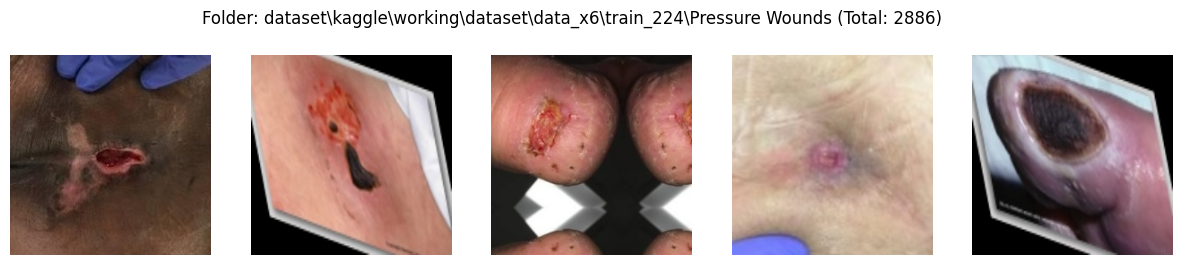

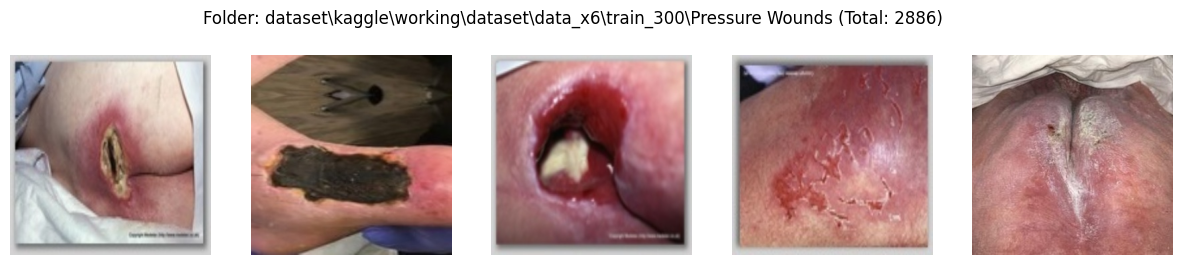

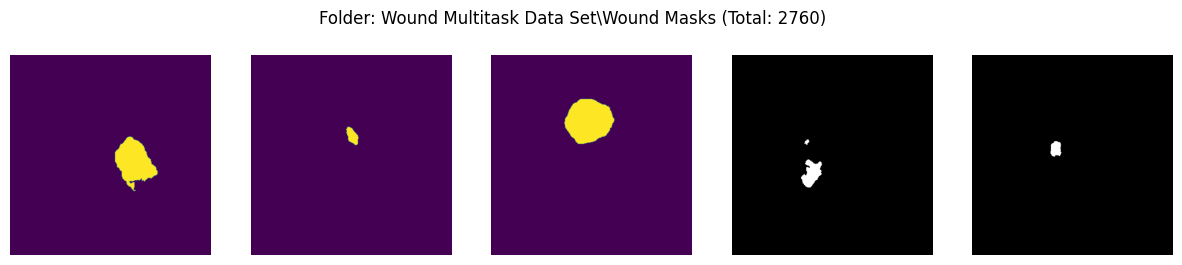

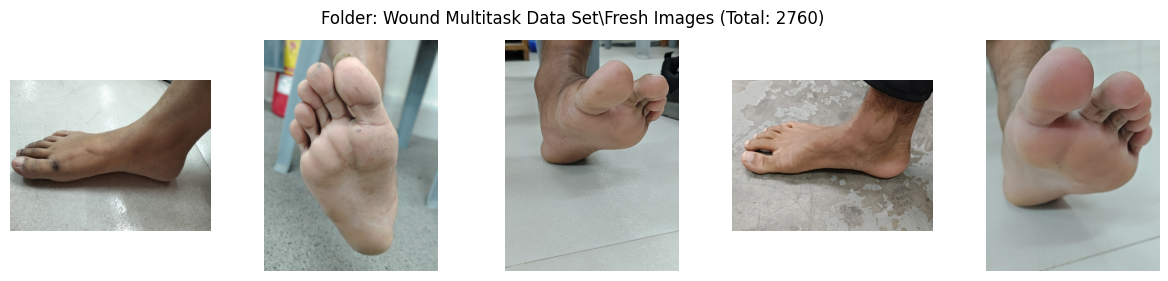

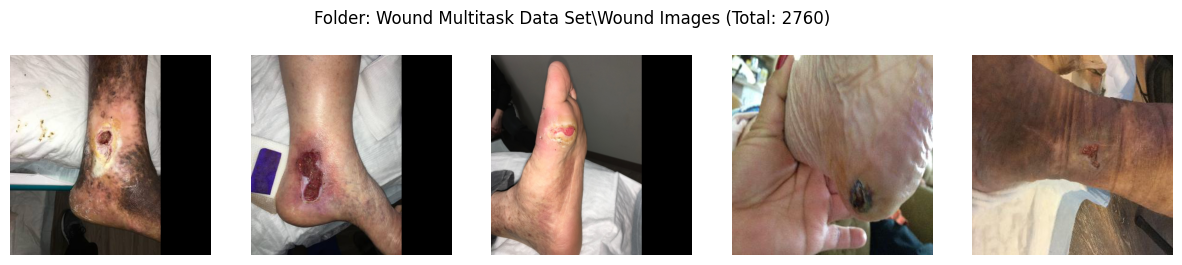

In [3]:
def show_samples(df, root_path, n=5):
    if df.empty:
        print("No images found!")
        return
        
    # Pick top 5 folders by count
    top_folders = df.sort_values(by='image_count', ascending=False).head(5)['folder_path'].tolist()
    
    for folder in top_folders:
        full_folder_path = os.path.join(root_path, folder)
        images = [f for f in os.listdir(full_folder_path) if f.lower().endswith(('.jpg', '.png'))]
        
        # Show a few
        sample_files = random.sample(images, min(len(images), 5))
        
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Folder: {folder} (Total: {len(images)})", fontsize=12)
        
        for i, img_file in enumerate(sample_files):
            try:
                img_path = os.path.join(full_folder_path, img_file)
                img = Image.open(img_path)
                plt.subplot(1, 5, i+1)
                plt.imshow(img)
                plt.axis('off')
            except Exception as e:
                print(f"Error reading {img_file}: {e}")
        plt.show()

print("Visualizing DFU Mixed Dataset samples...")
show_samples(df_dfu, SOURCES["DFU_Complex"])